<a href="https://colab.research.google.com/github/Jade-P/MLGroupProject/blob/Happy--Sohyun/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment & path Setup 

In [1]:
# Download dataset
!wget https://raw.githubusercontent.com/Jade-P/MLGroupProject/main/archive.zip

--2022-11-21 02:29:56--  https://raw.githubusercontent.com/Jade-P/MLGroupProject/main/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62587032 (60M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]  59.69M   352MB/s    in 0.2s    

2022-11-21 02:30:00 (352 MB/s) - ‘archive.zip’ saved [62587032/62587032]



In [ ]:
!unzip archive.zip

#Load Data

In [3]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
RANDOM_SEED = 123

In [4]:
TRAIN_DIR = ('Training/Training/')
TEST_DIR = ('Testing/Testing/')

In [5]:
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

In [6]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(emotions)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [7]:
IMG_SIZE= (48, 48)

In [8]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


28273 images loaded from Training/Training/ directory.


In [9]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [10]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:00<00:00, 12.71it/s]


7067 images loaded from Testing/Testing/ directory.


In [11]:
X_train.shape

(28273, 48, 48, 3)

#Data exploration

## Count number of images for each class

source: https://www.kaggle.com/code/apollo2506/facial-recognition

In [12]:
import pandas as pd

_, train_count = np.unique(y_train,return_counts=True)
_, test_count = np.unique(y_test,return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = emotions
data = df.rename(columns={0: "train", 1: "test", "Name" : "emotion"})
data

,train,test,emotion
0,3995,958,Angry
1,4097,1024,Fear
2,7215,1774,Happy
3,4965,1233,Neutral
4,4830,1247,Sad
5,3171,831,Suprise


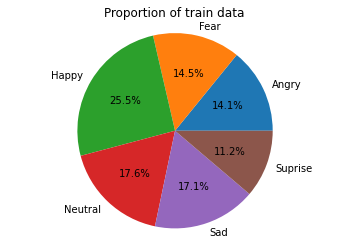

In [13]:
plt.pie(train_count,
       explode=(0,0,0,0,0,0),
       labels=emotions,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of train data")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


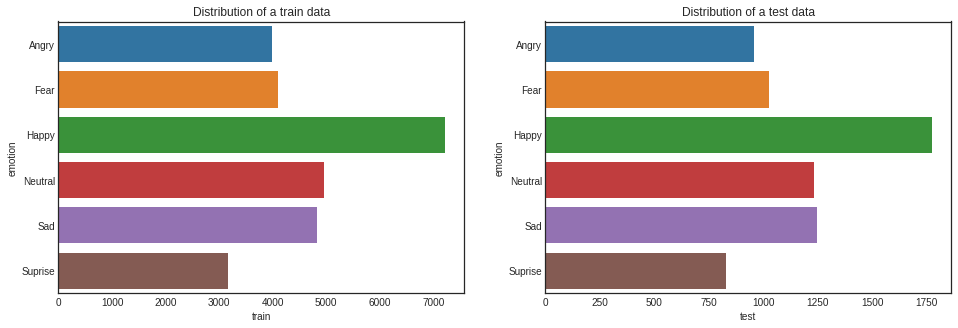

In [14]:
import seaborn as sns

plt.style.use('seaborn-white')
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(data["train"], data["emotion"], ax=ax[0])
ax[0].set_title("Distribution of a train data")
sns.barplot(data["test"], data["emotion"], ax=ax[1])
ax[1].set_title("Distribution of a test data")
plt.show()

## Size of Images

In [15]:
widths = dict()
heights = dict()

for img in X_train:
  width, height, _ = img.shape
  widths[width] = widths.get(width,0)+1
  heights[height] = heights.get(height,0)+1

In [16]:
print(widths)
print(heights)

{48: 28273}
{48: 28273}


Every image is in size of 48 * 48, so we don't need resizing.

##Plot samples of data

Source: https://www.kaggle.com/code/basel99/facial-recognition

In [17]:
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

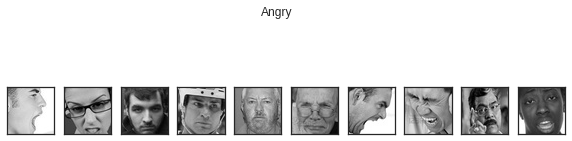

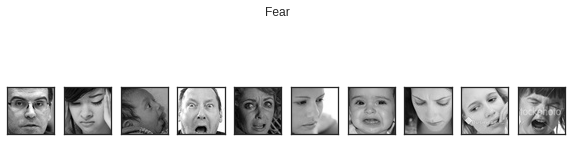

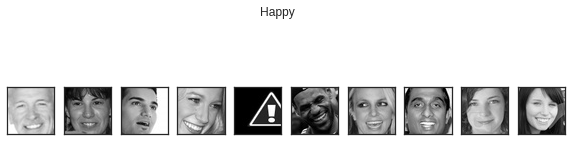

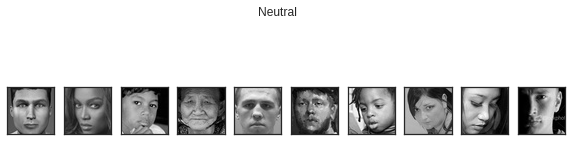

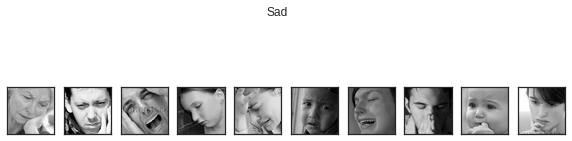

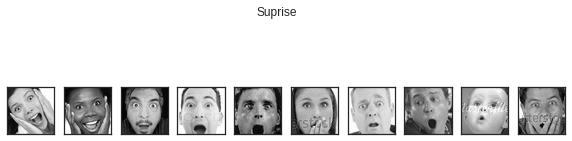

In [18]:
plot_samples(X_train, y_train, train_labels, 10)

#Data preprocessing

##Removing Duplicates

Remove duplicates of image to prevent overfitting.

resource: https://mizykk.tistory.com/55

In [19]:
import cv2  
from skimage.metrics import structural_similarity

image_list = []

path = TRAIN_DIR + '/Happy'

for f in os.listdir(path):
  image_list.append(f)

img_size = list(map(lambda x: os.path.getsize(path + '/' + x), image_list))

# Find Same Photos
img_data = pd.DataFrame({'filename':image_list, 'size':img_size})

print('number of images :', len(img_data))

number of images : 7215


In [20]:
img_data

,filename,size
0,Happy-3467.jpg,1294
1,Happy-4857.jpg,1603
2,Happy-3239.jpg,1378
3,Happy-3563.jpg,1500
4,Happy-6627.jpg,1259
...,...,...
7210,Happy-5699.jpg,1695
7211,Happy-4203.jpg,1582
7212,Happy-1931.jpg,1686
7213,Happy-419.jpg,1485


In [21]:
# Photo Value Counts
filename_cnts = pd.DataFrame({'filename':img_data['filename'].value_counts().index, 'fn_counts':img_data['filename'].value_counts().values})   
imgsize_cnts = pd.DataFrame({'size':img_data['size'].value_counts().index, 'size_counts':img_data['size'].value_counts().values})   

img_data = pd.merge(img_data, filename_cnts, how = 'left', on = 'filename')
img_data = pd.merge(img_data, imgsize_cnts, how = 'left', on = 'size')

img_data.sample(2)

,filename,size,fn_counts,size_counts
6657,Happy-7131.jpg,1610,1,18
5930,Happy-828.jpg,1479,1,13


In [22]:
SimilarSizeData = imgsize_cnts[imgsize_cnts['size_counts'] > 1]

###Use structural similarity to compare similarity of images

In [23]:
def CompareImage(imageA, imageB):

    # Grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Check Image structure
    if len(grayA)==len(grayB):
        (score, diff) = structural_similarity(grayA, grayB, full=True)

    return score

In [24]:
delete = dict()

In [25]:
for i in range(len(SimilarSizeData)):

    temp = img_data[img_data['size']==SimilarSizeData['size'][i]].reset_index(drop = True).sort_values(['filename'])

    for j in range(len(temp) - 1):
      filenameA = temp['filename'][j]
      compared = False

      for key in delete:
        if (filenameA in delete[key]):
          compared = True
          break
      
      if compared:
        continue

      for k in range(j+1, len(temp)):
        filenameB = temp['filename'][k]
        
        imageA = cv2.imread(path+'/'+filenameA)
        imageB = cv2.imread(path+'/'+filenameB)

        score = CompareImage(imageA, imageB)
        
        if (score == 1 or score > 0.6):
          if filenameA not in delete:
            delete[filenameA] = [filenameB]
          else:
            delete[filenameA].append(filenameB)
          if (score < 1):
            print(filenameA + ", " + filenameB)
            print("score: " + str(score))
          

Happy-6680.jpg, Happy-2461.jpg
score: 0.7168389603349193


### See if similar images are similar enough to be removed

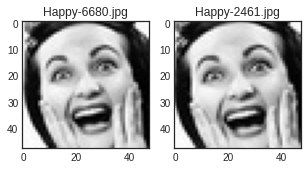

In [26]:
plt.figure(0, figsize=(5,3))
ax = plt.subplot(1,2,1)
ax.set_title('Happy-6680.jpg')
img1 = cv2.imread(path+"/"+ 'Happy-6680.jpg')
plt.imshow(img1,cmap="gray")

ax = plt.subplot(1,2,2)
ax.set_title('Happy-2461.jpg')
img2 = cv2.imread(path+"/"+ 'Happy-2461.jpg')
plt.imshow(img2,cmap="gray")

In [27]:
total = [len(value) for key, value in delete.items()]
print(str(sum(total)) + " duplicates found")

129 duplicates found


###Plotting some duplicates to confirm they are the same

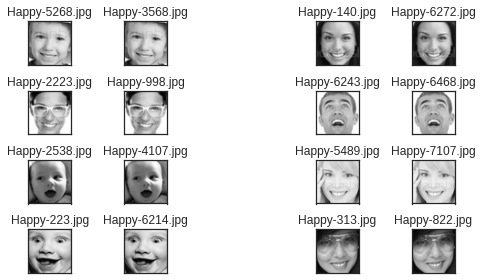

In [28]:
plt.figure(0, figsize=(8,4))
cpt = 0

n = 8

for key in delete:
  if (n == 0):
    break

  cpt += 1
  ax = plt.subplot(4,6,cpt)
  ax.set_title(key)
  img = cv2.imread(path+"/"+ key)
  plt.tick_params(labelleft=False,labelbottom=False)
  plt.imshow(img,cmap="gray")

  for file in delete[key]:
    cpt += 1
    ax = plt.subplot(4,6,cpt)
    ax.set_title(file)

    img = cv2.imread(path+"/"+ file)
    plt.tick_params(labelleft=False,labelbottom=False)
    plt.imshow(img,cmap="gray")
    pass
  
  if (cpt % 3 != 0):
    cpt +=1
  n -= 1

plt.tight_layout()
plt.show()

In [29]:
orig_list = image_list

print("original image number: " + str(len(orig_list)))

original image number: 7215


In [30]:
for key in delete:
  for val in delete[key]:
    image_list.remove(val)

print("updated images number: " + str(len(image_list)))

updated images number: 7086


###Remove images

In [ ]:
for key in delete:
  print("Removing duplicates of " + key)
  for val in delete[key]:
    print(val + " removed")
    os.remove(TRAIN_DIR + "Happy/" + val)

###Removing Duplicates (Repeat for other classes)

In [32]:
import cv2  
from skimage.metrics import structural_similarity

def getImgData(path):

  image_list = []

  for f in os.listdir(path):
    image_list.append(f)

  img_size = list(map(lambda x: os.path.getsize(path + '/' + x), image_list))

  img_data = pd.DataFrame({'filename':image_list, 'size':img_size})

  print('number of images :', len(img_data))
  return img_data

In [33]:
def getDuplicates(img_data):
  # Photo Value Counts
  imgsize_cnts = pd.DataFrame({'size':img_data['size'].value_counts().index, 'size_counts':img_data['size'].value_counts().values})   
  img_data = pd.merge(img_data, imgsize_cnts, how = 'left', on = 'size')
  SimilarSizeData = imgsize_cnts[imgsize_cnts['size_counts'] > 1]

  delete = dict()

  for i in range(len(SimilarSizeData)):
    temp = img_data[img_data['size']==SimilarSizeData['size'][i]].reset_index(drop = True).sort_values(['filename'])

    for j in range(len(temp) - 1):
      filenameA = temp['filename'][j]
      compared = False

      for key in delete:
        if (filenameA in delete[key]):
          compared = True
          break
      
      if compared:
        continue

      for k in range(j+1, len(temp)):
        filenameB = temp['filename'][k]
        
        imageA = cv2.imread(path+'/'+filenameA)
        imageB = cv2.imread(path+'/'+filenameB)

        score = CompareImage(imageA, imageB)
        
        if (score == 1 or score > 0.6):
          if filenameA not in delete:
            delete[filenameA] = [filenameB]
          else:
            delete[filenameA].append(filenameB)
          if (score < 1):
            print(filenameA + ", " + filenameB)
            print("score: " + str(score))
          
    total = [len(value) for key, value in delete.items()]
    print(str(sum(total)) + " duplicates found")

    return delete

In [34]:
def plotDuplicates(path, delete):

    plt.figure(0, figsize=(8,4))
    cpt = 0

    n = 8
    
    for key in delete:
      if (n == 0):
        break

      cpt += 1
      ax = plt.subplot(4,6,cpt)
      ax.set_title(key)
      img = cv2.imread(path+"/"+ key)
      plt.tick_params(labelleft=False,labelbottom=False)
      plt.imshow(img,cmap="gray")

      for file in delete[key]:
        cpt += 1
        ax = plt.subplot(4,6,cpt)
        ax.set_title(file)

        img = cv2.imread(path+"/"+ file)
        plt.tick_params(labelleft=False,labelbottom=False)
        plt.imshow(img,cmap="gray")
        pass
      
      while (cpt % 4 != 0):
        cpt +=1
      n -= 1

    plt.tight_layout()
    plt.show()

In [35]:
def removeDuplicates(path, delete, image_list):
    orig_list = image_list
    print("original image number: " + str(len(orig_list)))

    for key in delete:
      for val in delete[key]:
        image_list.remove(val)
    print("updated images number: " + str(len(image_list)))

    remove_cnt = 0

    for key in delete:
      for val in delete[key]:
        os.remove(path + "/" + val)
        remove_cnt +=1

    print(str(remove_cnt) + " number of duplicates removed")

Finding for duplicates in class Angry...
number of images : 3995
Angry-1718.jpg, Angry-1917.jpg
score: 0.8265641046829441
4 duplicates found


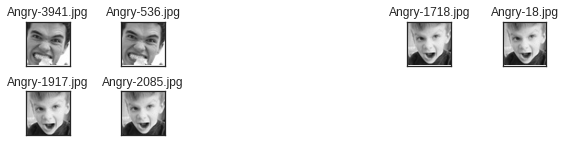

original image number: 3995
updated images number: 3991
4 number of duplicates removed


Finding for duplicates in class Fear...
number of images : 4097
4 duplicates found


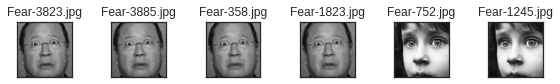

original image number: 4097
updated images number: 4093
4 number of duplicates removed


Finding for duplicates in class Happy...
number of images : 7086
0 duplicates found


<Figure size 576x288 with 0 Axes>

original image number: 7086
updated images number: 7086
0 number of duplicates removed


Finding for duplicates in class Neutral...
number of images : 4965
0 duplicates found


<Figure size 576x288 with 0 Axes>

original image number: 4965
updated images number: 4965
0 number of duplicates removed


Finding for duplicates in class Sad...
number of images : 4830
2 duplicates found


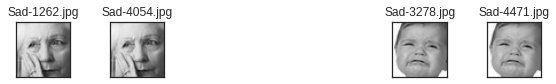

original image number: 4830
updated images number: 4828
2 number of duplicates removed


Finding for duplicates in class Suprise...
number of images : 3171
6 duplicates found


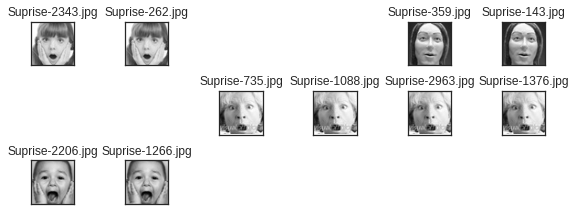

original image number: 3171
updated images number: 3165
6 number of duplicates removed




In [36]:
for emotion in emotions:
  print("Finding for duplicates in class " + emotion + "...")

  path = TRAIN_DIR + emotion
  image_list = []

  for f in os.listdir(path):
    image_list.append(f)

  img_data = getImgData(path)
  delete_list = getDuplicates(img_data)
  plotDuplicates(path, delete_list)
  removeDuplicates(path, delete_list, image_list)

  print("\n")

##Removing outliers (faulty inputs)

Remove image that doesn't look like a face, or includes more than one face. Outliers were found manually.

In [37]:
Happy_outliers = [1414,2541,4488,5326,1091,1817,2039,2226,2250,2819,3964,4123,6270,6441,6627]

In [38]:
path = TRAIN_DIR + "Happy"

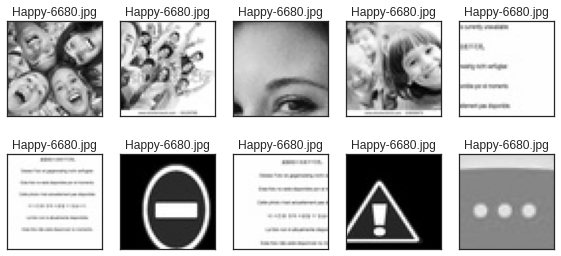

In [39]:
plt.figure(0, figsize=(8,4))
cpt = 0

n = 10

for outlier in Happy_outliers:
  if (n == 0):
    break

  cpt += 1
  ax = plt.subplot(2,5,cpt)
  ax.set_title(key)
  img = cv2.imread(path+"/"+ "Happy-" + str(outlier) + ".jpg")
  plt.tick_params(labelleft=False,labelbottom=False)
  plt.imshow(img,cmap="gray")

  n -= 1

plt.tight_layout()
plt.show()

In [40]:
for outlier in Happy_outliers:
  os.remove(TRAIN_DIR + "Happy/Happy-" + str(outlier) + ".jpg")

In [41]:
emotions

['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

###Repeat for other classes

In [42]:
outliers = {'Angry': [786, 930, 1078, 1596, 1730, 1835, 1866, 2185, 2822, 2903, 3091, 3384, 3714, 3975], 
            'Fear':[768, 562], 
            'Neutral':[1058, 2062, 2156, 2657, 2997, 3392, 363, 3767, 3977, 4186, 4352, 4473, 4859], 
            'Sad':[],
            'Suprise':[80, 128, 211, 213, 233, 259, 300, 309, 312, 335, 353, 596, 611, 665, 758, 1288, 1499, 2055, 2214, 2276]}

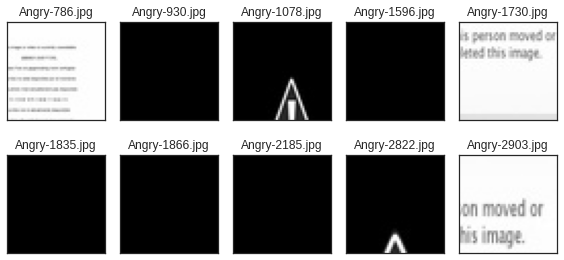

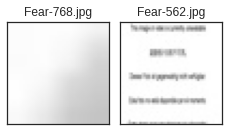

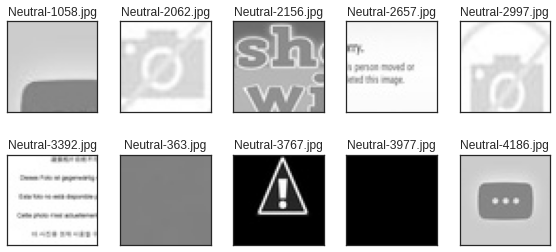

<Figure size 576x288 with 0 Axes>

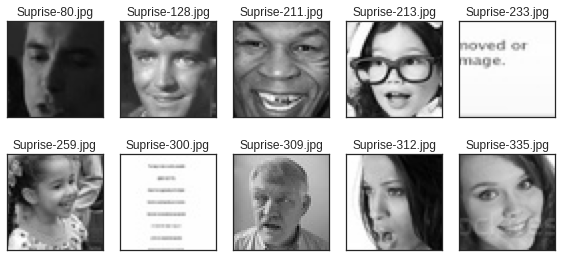

In [43]:
for emotion in outliers:
  path = TRAIN_DIR + emotion

  plt.figure(0, figsize=(8,4))
  cpt = 0

  n = 10

  for outlier in outliers[emotion]:
    if (n == 0):
      break

    cpt += 1
    ax = plt.subplot(2,5,cpt)
    img_name = emotion + "-" + str(outlier) + ".jpg"
    ax.set_title(img_name)
    img = cv2.imread(path+"/"+ img_name)
    plt.tick_params(labelleft=False,labelbottom=False)
    plt.imshow(img,cmap="gray")

    n -= 1

  plt.tight_layout()
  plt.show()

  #remove outlier
  for outlier in outliers[emotion]:
    os.remove(path + "/" + emotion + "-" + str(outlier) + ".jpg")

##Load Data (after preprocessing)

In [44]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(emotions)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file, cv2.IMREAD_GRAYSCALE)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [45]:
IMG_SIZE= (48, 48)

In [46]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


28064 images loaded from Training/Training/ directory.


In [47]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [48]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:00<00:00, 15.83it/s]

7067 images loaded from Testing/Testing/ directory.


In [49]:
X_train.shape

(28064, 48, 48)

About 200 images removed in total!

##Final data distribution

In [50]:
_, train_count = np.unique(y_train,return_counts=True)
_, test_count = np.unique(y_test,return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = emotions
data = df.rename(columns={0: "train", 1: "test", "Name" : "emotion"})

In [51]:
data_after = df.rename(columns={0: "Training Data", 1: "Testing Data","Name" : "Emotions"})
data_after = data_after.set_index("Emotions")
data_after

,Training Data,Testing Data
Emotions,,
Angry,3977,958
Fear,4091,1024
Happy,7071,1774
Neutral,4952,1233
Sad,4828,1247
Suprise,3145,831


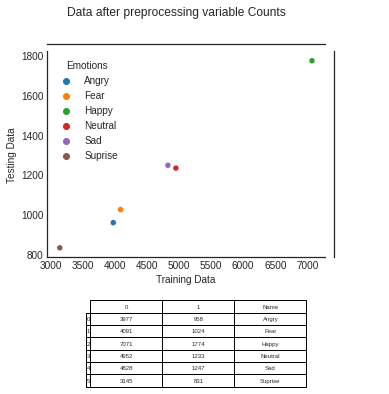

In [52]:
import seaborn as sns
#preprocessing table 
sns.jointplot(data=data_after, x="Training Data", y="Testing Data",hue = "Emotions")

plt.suptitle('Data after preprocessing variable Counts')
plt.subplots_adjust(left=0.2, bottom=0.4)
table = plt.table(cellText=df.values,
          rowLabels=df.index,
          colLabels=df.columns,
          cellLoc = 'center', rowLoc = 'center',
          transform=plt.gcf().transFigure,
          bbox = ([0.3, 0.1, 0.5, 0.2]))
table.auto_set_font_size(False)
table.set_fontsize(6)
plt.savefig('table.pdf',bbox_inches='tight')

##Encoding Classes

One-hot encoding with the emotion class

In [53]:
type(y_train)

numpy.ndarray

In [54]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

##Normalization

This is demonstration of normalizing single image. It will be done when we are actually training/building the model.

In [55]:
img = X_train[0]

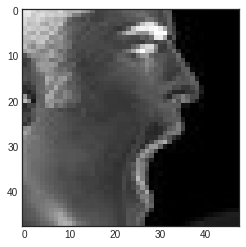

In [56]:
norm_image = (img - np.min(img)) / (np.max(img) - np.min(img))
plt.imshow(norm_image)

In [57]:
np.array_equal(img, norm_image)

False

#Sources

https://www.kaggle.com/code/basel99/facial-recognition

https://mizykk.tistory.com/55

https://www.kaggle.com/code/apollo2506/facial-recognition